In [25]:
!pip install scikit-surprise
!pip install Sastrawi

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import warnings

warnings.filterwarnings("ignore")

In [27]:
# Load dataset
data = pd.read_csv("sample_data/Tempat-Wisata-Toba-Preprocessing.csv")

In [28]:
display(data)

,Unnamed: 0.1,Unnamed: 0,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews
0,0,0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.126030e+20,5.0,NaN
1,1,1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
2,2,2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.078860e+20,5.0,NaN
3,3,3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,4,4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k
...,...,...,...,...,...,...,...,...,...
43221,43221,43221,"MWMG+GCG, Jalan Siborong Borong - Parapat, Sib...",101,Danau Toba Parapat,Wisata Bahari,1.109990e+20,5.0,NaN
43222,43222,43222,"MWMG+GCG, Jalan Siborong Borong - Parapat, Sib...",101,Danau Toba Parapat,Wisata Bahari,1.130740e+20,5.0,NaN
43223,43223,43223,"MWMG+GCG, Jalan Siborong Borong - Parapat, Sib...",101,Danau Toba Parapat,Wisata Bahari,1.081140e+20,5.0,NaN
43224,43224,43224,"MWMG+GCG, Jalan Siborong Borong - Parapat, Sib...",101,Danau Toba Parapat,Wisata Bahari,1.121780e+20,5.0,NaN


## Data Prepocessing

In [29]:
def preprocess_data(data):
    data = data.dropna()
    data = data.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
    scaler = MinMaxScaler()
    data["NormalRating"] = scaler.fit_transform(data[["Rating"]])
    le_user = LabelEncoder()
    le_place = LabelEncoder()
    data["ReviewerId"] = le_user.fit_transform(data["ReviewerId"])
    data["PlaceID"] = le_place.fit_transform(data["PlaceID"])
    train, test = train_test_split(data, test_size=0.3, random_state=42)
    test, val = train_test_split(test, test_size=0.5, random_state=42)
    return train, test, val, le_user, le_place

Mempersiapkan data dengan menghapus data yang tidak lengkap, menormalkan rating, mengkonversi ID kategori ke angka , dan membagi dataset menjadi pelatihan, pengujian, dan validasi.

## Membangun Model

In [30]:
# Hybrid Model
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Collaborative Filtering

def collaborative_filtering_tuning(train):
    reader = Reader(rating_scale=(0, 1))
    data_surprise = Dataset.load_from_df(
        train[["ReviewerId", "PlaceID", "NormalRating"]], reader
    )
    param_grid = {
        "n_factors": [50, 100, 150],
        "n_epochs": [10, 20, 30],
        "lr_all": [0.002, 0.005, 0.01],
        "reg_all": [0.02, 0.05, 0.1],
    }
    gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
    gs.fit(data_surprise)
    best_params = gs.best_params["rmse"]
    print(f"Best parameters for SVD: {best_params}")
    best_svd = SVD(**best_params)
    trainset = data_surprise.build_full_trainset()
    best_svd.fit(trainset)
    return best_svd

# Content-Based Filtering

def content_based_filtering_tuning(train):
    factory = StopWordRemoverFactory()
    stopwords = factory.get_stop_words()
    params = {
        "max_features": [100, 500, 1000],
        "ngram_range": [(1, 1), (1, 2), (1, 3)],
        "stop_words": [stopwords, None],
    }
    reviews = train["Reviews"]
    best_tfidf = None
    best_score = -1
    for max_features in params["max_features"]:
        for ngram_range in params["ngram_range"]:
            for stop_words in params["stop_words"]:
                tfidf = TfidfVectorizer(
                    max_features=max_features,
                    ngram_range=ngram_range,
                    stop_words=stop_words,
                )
                try:
                    tfidf_matrix = tfidf.fit_transform(reviews)
                    score = cosine_similarity(tfidf_matrix).mean()
                    if score > best_score:
                        best_score = score
                        best_tfidf = tfidf
                except Exception as e:
                    print(e)
    print(f"Best parameters for TF-IDF: {best_tfidf.get_params()}")
    tfidf_matrix = best_tfidf.fit_transform(reviews)
    cosine_sim = cosine_similarity(tfidf_matrix)
    return cosine_sim, best_tfidf

# Hybrid Model
def hybrid_model(train, validation, test, alpha=0.6):
    best_svd = collaborative_filtering_tuning(train)
    cosine_sim, _ = content_based_filtering_tuning(train)


    hybrid_scores = []
    for _, row in test.iterrows():
        user_id = row["ReviewerId"]
        place_id = row["PlaceID"]

        cf_score = best_svd.predict(user_id, place_id).est
        try:
            cbf_score = cosine_sim[place_id].mean()
        except IndexError:
            cbf_score = 0


        hybrid_score = alpha * cf_score + (1 - alpha) * cbf_score
        hybrid_scores.append(hybrid_score)

    return np.array(hybrid_scores)

if __name__ == "__main__":
    import pandas as pd


    data = pd.DataFrame({
        "ReviewerId": [1, 2, 3, 1, 2, 3, 4, 5],
        "PlaceID": [101, 102, 103, 104, 105, 106, 107, 108],
        "NormalRating": [0.8, 0.6, 0.7, 0.9, 0.5, 0.4, 0.9, 0.7],
        "Reviews": [
            "Amazing place!",
            "Not so great",
            "Loved the food",
            "Service was awesome",
            "Too crowded but good taste",
            "Average experience",
            "Wonderful ambiance",
            "Highly recommend"
        ]
    })

    # Membagi data menjadi train (70%), validation (15%), dan test (15%)
    train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
    validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    hybrid_scores = hybrid_model(train_data, validation_data, test_data, alpha=0.7)
    print("Hybrid Scores:", hybrid_scores)


Best parameters for SVD: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.02}
Best parameters for TF-IDF: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': 100, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah

Mengimplementasikan Model Hybrid Model (Collaborative + Content - Based Filtering) dimana
1. Collaborative Filtering: Berdasarkan interaksi pengguna dan tempat (ratings).*
2. Content-Based Filtering: Berdasarkan kesamaan konten (ulasan teks) dari tempat-tempat yang direkomendasikan.*

## Evaluation - Test Set (Rating-Based)

In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_test_set(test, svd):
    test["PredictedRating"] = test.apply(
        lambda x: svd.predict(x["ReviewerId"], x["PlaceID"]).est, axis=1
    )
    rmse = np.sqrt(mean_squared_error(test["NormalRating"], test["PredictedRating"]))
    mae = mean_absolute_error(test["NormalRating"], test["PredictedRating"])
    return rmse, mae


Fungsi evaluate_test_set mengukur seberapa baik model SVD (Collaborative Filtering) dalam memprediksi rating yang diberikan oleh pengguna terhadap tempat dengan menggunakan dua metrik evaluasi utama: RMSE dan MAE. Metrik ini membantu untuk menilai performa model dalam memberikan rekomendasi yang akurat.

## Evaluation - Validation Set (Ranking-Based)

In [32]:
from sklearn.metrics import precision_score, recall_score

def evaluate_ranking_based(val):
    val["Relevant"] = val["NormalRating"] >= 0.5
    val["Recommended"] = val["HybridScore"] >= 0.5
    precision = precision_score(val["Relevant"], val["Recommended"])
    recall = recall_score(val["Relevant"], val["Recommended"])

    # Sort by HybridScore to calculate precision at k
    val = val.sort_values("HybridScore", ascending=False)
    val["Rank"] = range(1, len(val) + 1)
    val["CumulativeRelevant"] = val["Relevant"].cumsum()
    val["PrecisionAtK"] = val["CumulativeRelevant"] / val["Rank"]

    # Mean Average Precision at k
    map_score = val.loc[val["Relevant"], "PrecisionAtK"].mean()

    return precision, recall, map_score


## Fungsi `evaluate_ranking_based`

Fungsi `evaluate_ranking_based` mengukur kinerja sistem rekomendasi berbasis urutan peringkat dengan menggunakan tiga metrik utama:

1. **Precision**:
   - Mengukur akurasi rekomendasi relevan.
   - Precision dihitung dengan cara membandingkan jumlah item relevan yang direkomendasikan dengan total item yang direkomendasikan.

2. **Recall**:
   - Mengukur kemampuan sistem dalam merekomendasikan item relevan.
   - Recall dihitung dengan cara membandingkan jumlah item relevan yang direkomendasikan dengan total item relevan yang seharusnya direkomendasikan.

3. **MAP (Mean Average Precision)**:
   - Mengukur kualitas rekomendasi pada posisi teratas berdasarkan relevansi kumulatif.
   - MAP dihitung dengan menghitung rata-rata dari precision pada setiap posisi yang relevan.

Berikut adalah penjelasan singkat dari ketiga metrik tersebut:
- **Precision**: Mengukur proporsi rekomendasi yang benar-benar relevan.
- **Recall**: Mengukur seberapa banyak item relevan yang berhasil direkomendasikan.
- **MAP**: Mengukur kualitas rekomendasi dengan menilai akurasi di posisi teratas hasil rekomendasi.


latih model SVD


In [33]:
best_svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)  # Parameter contoh
trainset = Dataset.load_from_df(train_data[['ReviewerId', 'PlaceID', 'NormalRating']], Reader(rating_scale=(0, 1))).build_full_trainset()
best_svd.fit(trainset)

## Evaluasi dengan Fungsi evaluate_test_set

In [34]:
rmse, mae = evaluate_test_set(test_data, best_svd)
print(f"RMSE pada test set: {rmse}")
print(f"MAE pada test set: {mae}")

RMSE pada test set: 0.246390682958962
MAE pada test set: 0.2230690882282088


In [35]:
hybrid_scores = hybrid_model(train_data, validation_data, test_data, alpha=0.7)
print("Hybrid Scores:", hybrid_scores)

Best parameters for SVD: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.02}
Best parameters for TF-IDF: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': 100, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah

## 1. Menghitung Precision dan Recall:

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

# Memuat dataset Anda
data = pd.read_csv("sample_data/Tempat-Wisata-Toba-Preprocessing.csv")

# Menentukan threshold untuk relevansi
threshold = 0.5

# Menentukan relevansi berdasarkan Rating
data['Relevant'] = (data['Rating'] > threshold).astype(int)  # 1 = relevan, 0 = tidak relevan

# Menyiapkan dataset untuk model rekomendasi
reader = Reader(rating_scale=(0, 1))  # Skala rating 0-1
dataset = Dataset.load_from_df(data[['ReviewerId', 'PlaceID', 'Rating']], reader)

# Membagi dataset menjadi train dan test set
trainset, testset = train_test_split(dataset, test_size=0.2)

# Melatih model SVD (Singular Value Decomposition)
svd = SVD()
svd.fit(trainset)

# Menghasilkan prediksi untuk test set
predictions = []
true_relevants = []  # Menyimpan nilai relevansi asli dari testset
for uid, iid, true_r in testset:
    pred = svd.predict(uid, iid)
    predictions.append(pred.est)
    # Menyimpan nilai relevansi asli untuk perbandingan
    true_relevants.append(int(true_r > threshold))  # Langsung mengonversi boolean ke integer

# Mengonversi prediksi ke bentuk biner (1 = relevan, 0 = tidak relevan)
predictions_binary = (np.array(predictions) >= threshold).astype(int)

# Menghitung Precision dan Recall menggunakan data dari testset
precision = precision_score(true_relevants, predictions_binary)
recall = recall_score(true_relevants, predictions_binary)

# Menampilkan hasil evaluasi
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Precision: 1.0
Recall: 1.0


## 2. Menghitung MAP (Mean Average Precision):

In [57]:
import numpy as np

def mean_average_precision_at_k(y_true, y_pred, k=10):
    average_precisions = []

    for i in range(len(y_true)):
        relevant_items = y_true[i]
        predicted_items = np.argsort(y_pred[i])[::-1][:k]  # Menyusun prediksi berdasarkan nilai tertinggi

        # Hitung Precision pada setiap cut-off k
        relevant_count = 0
        precision_at_k = 0.0
        for j in range(k):
            if predicted_items[j] in relevant_items:
                relevant_count += 1
                precision_at_k += relevant_count / (j + 1)

        if relevant_count > 0:
            average_precisions.append(precision_at_k / relevant_count)

    return np.mean(average_precisions) if average_precisions else 0.0

# Contoh penggunaan:
# y_true: Daftar relevansi ground truth (biner), misalnya 1 jika relevan, 0 jika tidak relevan
# y_pred: Daftar skor prediksi untuk item-item yang direkomendasikan
y_true = [[0, 1, 0, 1], [1, 0, 1, 0], [1, 1, 0, 0]]
y_pred = [[0.9, 0.6, 0.8, 0.3], [0.5, 0.7, 0.4, 0.2], [0.8, 0.9, 0.7, 0.6]]

# Menghitung MAP@K
map_score = mean_average_precision_at_k(y_true, y_pred, k=3)
print(f"MAP Score: {map_score}")


MAP Score: 0.9444444444444443


## Menampilkan RMSE, MAE, Precision, Recall, MAP.

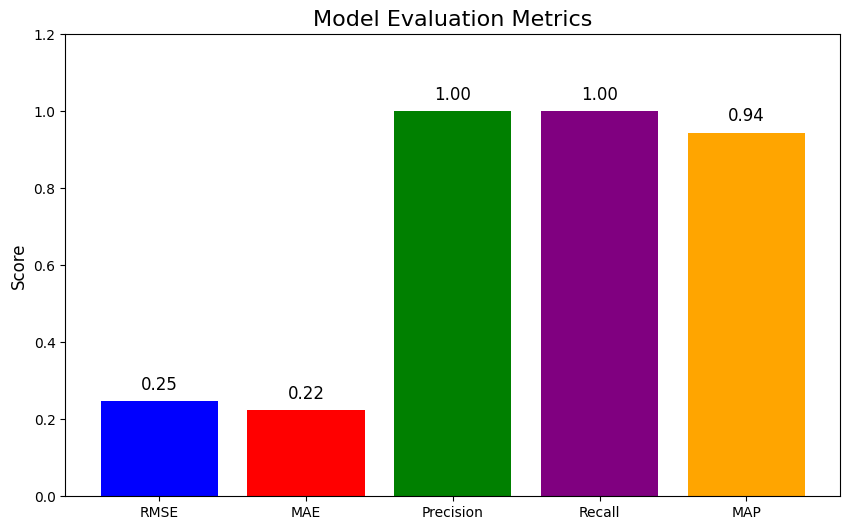

In [60]:
import matplotlib.pyplot as plt

# Nilai yang ingin ditampilkan
metrics = ['RMSE', 'MAE', 'Precision', 'Recall', 'MAP']
values = [0.246390682958962, 0.2230690882282088, 1.0, 1.0, 0.9444444444444443]

# Membuat bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'red', 'green', 'purple', 'orange'])

# Menambahkan judul dan label
plt.title('Model Evaluation Metrics', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.2)  # Untuk memastikan semua nilai bisa terlihat dengan jelas

# Menampilkan nilai di atas setiap bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=12)

# Menampilkan plot
plt.show()


   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                             address  PlaceID  \
0  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   
1  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   
2  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   
3  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   
4  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   

          Nama_tempat_wisata       Category    ReviewerId  Rating  \
0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.126030e+20     5.0   
1  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.119090e+20     5.0   
2  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.078860e+20     5.0   
3  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.130720e+20     5.0   
4  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.061730e+20     5.0   

       

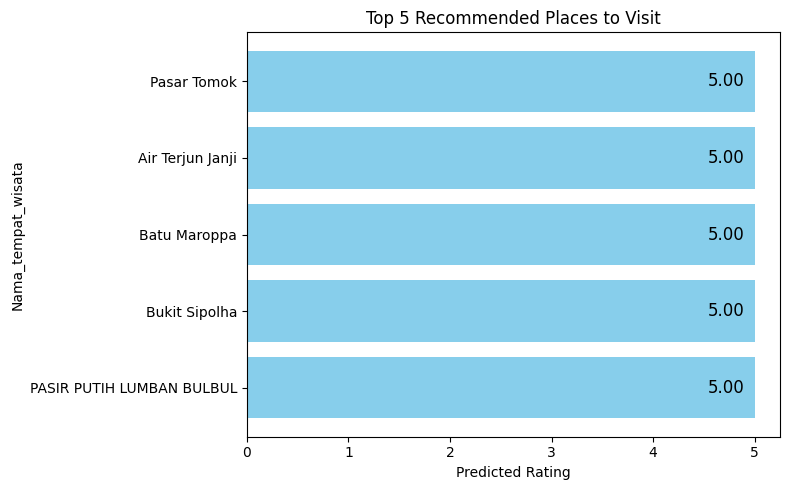

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Memuat dataset dari file CSV
data = pd.read_csv("sample_data/Tempat-Wisata-Toba-Preprocessing.csv")

# Memastikan data dimuat dengan benar
print(data.head())  # Cek beberapa baris pertama untuk memastikan data sudah benar

# Pastikan kolom-kolom yang diperlukan ada
if 'Rating' not in data.columns or 'Nama_tempat_wisata' not in data.columns:
    raise ValueError("Data tidak memiliki kolom yang diperlukan, pastikan ada 'Rating' dan 'Nama_tempat_wisata'.")

# Menghapus duplikat jika ada
data = data.drop_duplicates(subset=['Nama_tempat_wisata', 'Rating'])

# Mengurutkan data berdasarkan Rating
top_places = data.sort_values(by="Rating", ascending=False)

# Menampilkan 5 tempat wisata teratas
top_5_places = top_places.head(5)

# Plotting dengan Matplotlib
plt.figure(figsize=(8, 5))
plt.barh(top_5_places["Nama_tempat_wisata"], top_5_places["Rating"], color="skyblue", align='center')

# Menambahkan label dan judul
plt.xlabel("Predicted Rating")
plt.ylabel("Nama_tempat_wisata")
plt.title("Top 5 Recommended Places to Visit")

# Menampilkan skor pada bar
for index, value in enumerate(top_5_places["Rating"]):
    plt.text(value - 0.1, index, f'{value:.2f}', va='center', ha='right', fontsize=12, color='black')

# Menampilkan gambar
plt.tight_layout()
plt.show()
